<a href="https://colab.research.google.com/github/anishareddy04/ML_CSE_21206A/blob/main/Unveiling%20mental%20health%20insights%3A%20twitter%20text%20analysis%20using%20NMF%20and%20clustring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=8ac5022f52bb192372ac80a0a4b1daa214b496c51e12b3b9a8197d2b870eee51
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
import lime
from lime.lime_tabular import LimeTabularExplainer



In [ ]:

# Load data
df = pd.read_csv("new_dataset1 (1).csv", encoding='latin-1')

# Your preprocessing
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "TweetText"]
df.columns = DATASET_COLUMNS

# Preprocess data
df['target'] = df['target'].replace({4: 1})
df = df.drop(['flag','date'], axis = 1)

df_positive = df[df.target==1]
df_negative = df[df.target==0]
df = pd.concat([df_positive,df_negative],axis = 0)
print(df.shape)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    clean_text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return clean_text

# Clean tweets
def cleanup_tweets(df):
    # remove handle
    df['clean_tweet'] = df['TweetText'].str.replace("@", "")
    # remove links
    df['clean_tweet'] = df['clean_tweet'].str.replace(r"http\S+", "")
    # remove punctuations and special characters
    df['clean_tweet'] = df['clean_tweet'].str.replace("[^a-zA-Z]", " ")
    # remove stop words
    df['clean_tweet'] = df['clean_tweet'].apply(lambda text : remove_stopwords(text.lower()))
    # split text and tokenize
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: x.split())
    # let's apply stemmer
    stemmer = PorterStemmer()
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: [stemmer.stem(i) for i in x])
    # stitch back words
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: ' '.join([w for w in x]))
    # remove small words
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
cleanup_tweets(df)

(16000, 4)


<ipython-input-4-c47d0d76f4ed>:27: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_tweet'] = df['clean_tweet'].str.replace(r"http\S+", "")
<ipython-input-4-c47d0d76f4ed>:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_tweet'] = df['clean_tweet'].str.replace("[^a-zA-Z]", " ")


In [ ]:
df

target         ids            user  \
6           1  1983449090        jessig06   
9           1  2050057894        AmiAhuja   
10          1  2052206835        salmafan   
11          1  1992273171      spanishman   
12          1  2069921255    DannyMacRant   
...       ...         ...             ...   
15985       0  1958094323  serenityangels   
15987       0  2206890340      spamalot77   
15990       0  1974544821          XINEEE   
15997       0  2070002911  claireredfield   
15998       0  2069388399  ReadRightnBlew   

                                               TweetText  \
6                on lunch....dj should come eat with me    
9      @TamaraSchilling Adventure - That's what we al...   
10     @PerezHilton Zach makes me pee sitting down! A...   
11     to sum up my day in one word ......... kackered!    
12                       @k9wkj Great minds think alike    
...                                                  ...   
15985  Acquiring a CentOS live CD, now where did I pu...   
15987      cannot believe fees for Baruch are going up!    
15990  I just woke up all sweaty with tears from a re...   
15997  @realface Anything else crappy happen in Johnn...   
15998  @The_Monarch I SO don't know what you mean- I ...   

                                             clean_tweet  
6                                             lunch come  
9      tamaraschil adventur need life glad great week...  
10                           perezhilton zach make grown  
11                                           word kacker  
12                                 great mind think alik  
...                                                  ...  
15985  acquir cento live memori stick would like boot...  
15987                               cannot believ baruch  
15990  woke sweati tear realli dream believ slept hou...  
15997  realfac anyth crappi happen johnni know tegoma...  
15998  monarch know mean think korean cartoon avatar ...  

[16000 rows x 5 columns]

In [ ]:

# Feature Extraction with TF-IDF and NMF
vectorizer = TfidfVectorizer(max_features=5000, max_df=0.85, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['clean_tweet'])

# Apply NMF clustering
num_topics = 5
nmf = NMF(n_components=num_topics, random_state=42)
nmf_features = nmf.fit_transform(tfidf_matrix)

# Apply KMeans clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(nmf_features)


# Combine TF-IDF with original, NMF and KMeans
combined_features = np.concatenate([tfidf_matrix.toarray(), nmf_features, kmeans_labels.reshape(-1, 1)], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Train
X_train, X_test, y_train, y_test = train_test_split(combined_features, df['target'], test_size=0.2, random_state=42)

In [ ]:
# Add these lines to your existing code

# Import necessary libraries
import lime
from lime import lime_text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# Sample data (replace with your actual data)
texts = ["This is a positive example.", "This is a negative example.", "Another positive instance."]
labels = [1, 0, 1]


# Create a classifier (replace with your actual model)
classifier = make_pipeline(vectorizer, RandomForestClassifier())
classifier.fit(texts, labels)

# Create the LIME explainer
explainer = lime_text.LimeTextExplainer()

# Select an instance for which you want to explain the prediction
instance_idx = 0
instance = texts[instance_idx]

# Explain the prediction using LIME
explanation = explainer.explain_instance(instance, classifier.predict_proba)

# Visualize the explanation
explanation.show_in_notebook(text=True)


In [ ]:
# Import necessary libraries
import lime
from lime import lime_text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# Sample data (replace with your actual data)
# Assuming df is your DataFrame with 'clean_tweet' column and 'label' column
texts = df['TweetText'].tolist()
labels = df['target'].tolist()

# Create a CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

# Create a classifier (replace with your actual model)
classifier = make_pipeline(vectorizer, RandomForestClassifier())
classifier.fit(texts, labels)

# Create the LIME explainer
explainer = lime_text.LimeTextExplainer()

# Select an instance for which you want to explain the prediction
instance_idx = 0
instance = texts[instance_idx]

# Explain the prediction using LIME
explanation = explainer.explain_instance(instance, classifier.predict_proba)

# Visualize the explanation
explanation.show_in_notebook(text=True)


In [ ]:
# Train and Evaluate Random Forest on Original TF-IDF Features
rf_original = RandomForestClassifier(random_state=42)
rf_original.fit(X_train[:, :tfidf_matrix.shape[1]], y_train)

# Predictions on training set
y_train_pred_rf_original = rf_original.predict(X_train[:, :tfidf_matrix.shape[1]])

# Predictions on testing set
y_test_pred_rf_original = rf_original.predict(X_test[:, :tfidf_matrix.shape[1]])

# Accuracy for training set
accuracy_rf_train_original = accuracy_score(y_train, y_train_pred_rf_original)
print("\nAccuracy with Original TF-IDF Features on Training Set (RF):", accuracy_rf_train_original)

# Accuracy for testing set
accuracy_rf_original = accuracy_score(y_test, y_test_pred_rf_original)
print("\nAccuracy with Original TF-IDF Features on Testing Set (RF):", accuracy_rf_original)
print("Classification Report for Original TF-IDF Features (RF):\n", classification_report(y_test, y_test_pred_rf_original))

# Train and Evaluate Random Forest on Combined Features (TF-IDF + NMF)
rf_combined = RandomForestClassifier(random_state=42)
rf_combined.fit(combined_features, df['target'])

# Predictions on training set
y_train_pred_rf_combined = rf_combined.predict(X_train)

# Predictions on testing set
y_test_pred_rf_combined = rf_combined.predict(X_test)

# Accuracy for training set
accuracy_rf_train_combined = accuracy_score(y_train, y_train_pred_rf_combined)
print("\nAccuracy with Combined Features (TF-IDF + NMF + KMeans) on Training Set (RF):", accuracy_rf_train_combined)

# Accuracy for testing set
accuracy_rf_combined = accuracy_score(y_test, y_test_pred_rf_combined)
print("\nAccuracy with Combined Features (TF-IDF + NMF + KMeans) on Testing Set (RF):", accuracy_rf_combined)
print("Classification Report for Combined Features (RF):\n", classification_report(y_test, y_test_pred_rf_combined))



Accuracy with Original TF-IDF Features on Training Set (RF): 0.97609375

Accuracy with Original TF-IDF Features on Testing Set (RF): 0.693125
Classification Report for Original TF-IDF Features (RF):
               precision    recall  f1-score   support

           0       0.70      0.67      0.68      1593
           1       0.69      0.72      0.70      1607

    accuracy                           0.69      3200
   macro avg       0.69      0.69      0.69      3200
weighted avg       0.69      0.69      0.69      3200


Accuracy with Combined Features (TF-IDF + NMF + KMeans) on Training Set (RF): 0.975

Accuracy with Combined Features (TF-IDF + NMF + KMeans) on Testing Set (RF): 0.9734375
Classification Report for Combined Features (RF):
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      1593
           1       0.96      0.99      0.97      1607

    accuracy                           0.97      3200
   macro avg       0.97      0

NMF Features:
    nmf_feature_1  nmf_feature_2
6        0.003896       0.000645
9        0.006879       0.080471
10       0.002922       0.000161
11       0.002060       0.002491
12       0.006605       0.003893

KMeans Cluster Labels:
0    13310
1     1009
2      735
3      514
4      432
Name: kmeans_label, dtype: int64


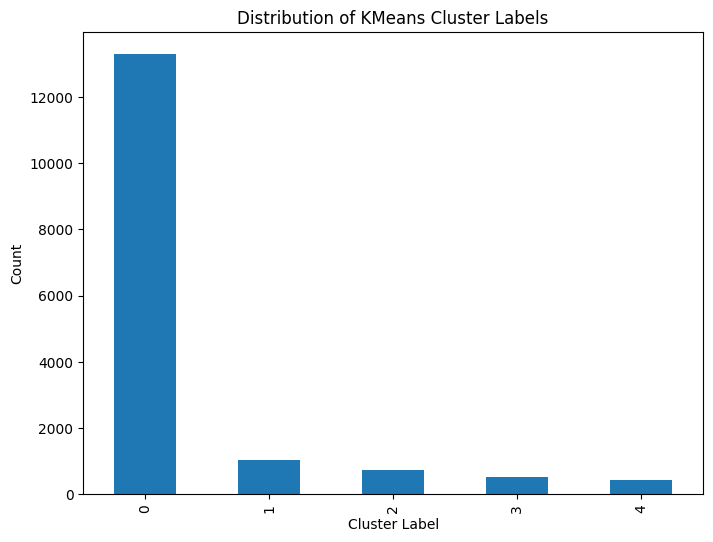

In [ ]:
# Add NMF features and KMeans labels to the DataFrame
df['nmf_feature_1'] = nmf_features[:, 0]  # Adjust column names as per your NMF features
df['nmf_feature_2'] = nmf_features[:, 1]
df['kmeans_label'] = kmeans_labels

# Print or visualize the NMF features and KMeans labels
print("NMF Features:")
print(df[['nmf_feature_1', 'nmf_feature_2']].head())  # Adjust column names as per your NMF features
print("\nKMeans Cluster Labels:")
print(df['kmeans_label'].value_counts())

# Visualize the distribution of KMeans labels
plt.figure(figsize=(8, 6))
df['kmeans_label'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of KMeans Cluster Labels')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

In [ ]:
df

target         ids            user  \
6           1  1983449090        jessig06   
9           1  2050057894        AmiAhuja   
10          1  2052206835        salmafan   
11          1  1992273171      spanishman   
12          1  2069921255    DannyMacRant   
...       ...         ...             ...   
15985       0  1958094323  serenityangels   
15987       0  2206890340      spamalot77   
15990       0  1974544821          XINEEE   
15997       0  2070002911  claireredfield   
15998       0  2069388399  ReadRightnBlew   

                                               TweetText  \
6                on lunch....dj should come eat with me    
9      @TamaraSchilling Adventure - That's what we al...   
10     @PerezHilton Zach makes me pee sitting down! A...   
11     to sum up my day in one word ......... kackered!    
12                       @k9wkj Great minds think alike    
...                                                  ...   
15985  Acquiring a CentOS live CD, now where did I pu...   
15987      cannot believe fees for Baruch are going up!    
15990  I just woke up all sweaty with tears from a re...   
15997  @realface Anything else crappy happen in Johnn...   
15998  @The_Monarch I SO don't know what you mean- I ...   

                                             clean_tweet  kmeans_label  \
6                                             lunch come             0   
9      tamaraschil adventur need life glad great week...             4   
10                           perezhilton zach make grown             0   
11                                           word kacker             0   
12                                 great mind think alik             0   
...                                                  ...           ...   
15985  acquir cento live memori stick would like boot...             0   
15987                               cannot believ baruch             0   
15990  woke sweati tear realli dream believ slept hou...             3   
15997  realfac anyth crappi happen johnni know tegoma...             0   
15998  monarch know mean think korean cartoon avatar ...             0   

       nmf_feature_1  nmf_feature_2  
6           0.003896       0.000645  
9           0.006879       0.080471  
10          0.002922       0.000161  
11          0.002060       0.002491  
12          0.006605       0.003893  
...              ...            ...  
15985       0.008673       0.001580  
15987       0.001299       0.000546  
15990       0.005005       0.001038  
15997       0.006610       0.001498  
15998       0.006473       0.002320  

[16000 rows x 8 columns]

In [ ]:
# Assuming 'kmeans_label' is the column containing KMeans cluster labels in your DataFrame
cluster_0_data = df[df['kmeans_label'] == 0]

# Display or analyze the data points in Cluster 0
print(cluster_0_data)  # Display the first few rows of data in Cluster 0


       target         ids            user  \
6           1  1983449090        jessig06   
10          1  2052206835        salmafan   
11          1  1992273171      spanishman   
12          1  2069921255    DannyMacRant   
16          1  2190762188      biaromerok   
...       ...         ...             ...   
15982       0  1966900536          JSicka   
15985       0  1958094323  serenityangels   
15987       0  2206890340      spamalot77   
15997       0  2070002911  claireredfield   
15998       0  2069388399  ReadRightnBlew   

                                               TweetText  \
6                on lunch....dj should come eat with me    
10     @PerezHilton Zach makes me pee sitting down! A...   
11     to sum up my day in one word ......... kackered!    
12                       @k9wkj Great minds think alike    
16     i'm feeling quite sleepy today, wish i could s...   
...                                                  ...   
15982  Intercom at Walmart: To the owne

In [ ]:
# Train and Evaluate Random Forest on Original TF-IDF Features
rf_original = RandomForestClassifier(random_state=42)
rf_original.fit(X_train[:, :tfidf_matrix.shape[1]], y_train)

# Predictions on training set
y_train_pred_rf_original = rf_original.predict(X_train[:, :tfidf_matrix.shape[1]])

# Predictions on testing set
y_test_pred_rf_original = rf_original.predict(X_test[:, :tfidf_matrix.shape[1]])

# Accuracy for training set
accuracy_rf_train_original = accuracy_score(y_train, y_train_pred_rf_original)
print("\nAccuracy with Original TF-IDF Features on Training Set (RF):", accuracy_rf_train_original)

# Accuracy for testing set
accuracy_rf_original = accuracy_score(y_test, y_test_pred_rf_original)
print("\nAccuracy with Original TF-IDF Features on Testing Set (RF):", accuracy_rf_original)
print("Classification Report for Original TF-IDF Features (RF):\n", classification_report(y_test, y_test_pred_rf_original))

# Train and Evaluate Random Forest on Combined Features (TF-IDF + NMF)
rf_combined = RandomForestClassifier(random_state=42)
rf_combined.fit(combined_features, df['target'])

# Predictions on training set
y_train_pred_rf_combined = rf_combined.predict(X_train)

# Predictions on testing set
y_test_pred_rf_combined = rf_combined.predict(X_test)

# Accuracy for training set
accuracy_rf_train_combined = accuracy_score(y_train, y_train_pred_rf_combined)
print("\nAccuracy with Combined Features (TF-IDF + NMF) on Training Set (RF):", accuracy_rf_train_combined)

# Accuracy for testing set
accuracy_rf_combined = accuracy_score(y_test, y_test_pred_rf_combined)
print("\nAccuracy with Combined Features (TF-IDF + NMF) on Testing Set (RF):", accuracy_rf_combined)
print("Classification Report for Combined Features (RF):\n", classification_report(y_test, y_test_pred_rf_combined))



Accuracy with Original TF-IDF Features on Training Set (RF): 0.97609375

Accuracy with Original TF-IDF Features on Testing Set (RF): 0.693125
Classification Report for Original TF-IDF Features (RF):
               precision    recall  f1-score   support

           0       0.70      0.67      0.68      1593
           1       0.69      0.72      0.70      1607

    accuracy                           0.69      3200
   macro avg       0.69      0.69      0.69      3200
weighted avg       0.69      0.69      0.69      3200


Accuracy with Combined Features (TF-IDF + NMF) on Training Set (RF): 0.974921875

Accuracy with Combined Features (TF-IDF + NMF) on Testing Set (RF): 0.97375
Classification Report for Combined Features (RF):
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      1593
           1       0.96      0.99      0.97      1607

    accuracy                           0.97      3200
   macro avg       0.97      0.97      0.97 

In [ ]:
!pip install lime

In [ ]:
import lime
# Create Lime Explainer
feature_names = np.arange(combined_features.shape[1])
class_names = [0, 1]
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=class_names, discretize_continuous=True)

# Explain instance
i = 55
exp = explainer.explain_instance(X_test[i], rf_combined.predict_proba, num_features=10, top_labels=0)

# Print explanation
print('Explanation for test instance %d' %i)
print(exp.as_list())


Explanation for test instance 55
[('3837 <= 0.00', 0.1626160036516161), ('1378 <= 0.00', -0.15650146828745906), ('418 <= 0.00', -0.12920506658968461), ('3758 <= 0.00', -0.10208721448632767), ('654 <= 0.00', 0.10135420452266224), ('3147 <= 0.00', 0.08385671847770293), ('686 <= 0.00', 0.07731710014388463), ('504 <= 0.00', -0.07180533833349133), ('3079 <= 0.00', 0.06295314179617041), ('1028 <= 0.00', -0.0118695285469395)]


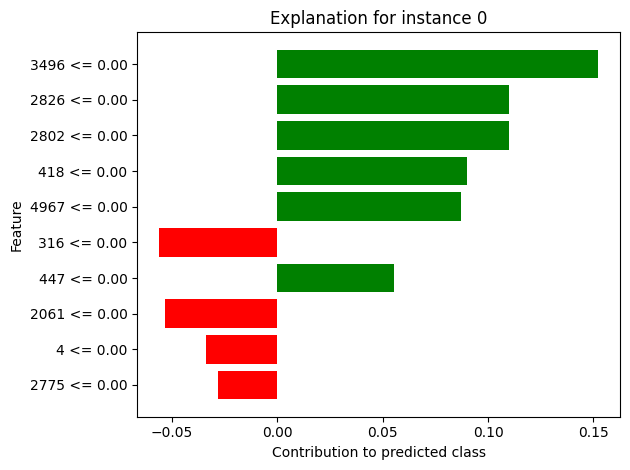

In [ ]:
from lime import lime_tabular
# Create Lime Explainer
feature_names = np.arange(combined_features.shape[1])
class_names = [0, 1]
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=class_names, discretize_continuous=True)

# Explain instance
i = 0

instance = X_test[i].reshape(5006,)
exp = explainer.explain_instance(instance, rf_combined.predict_proba, num_features=10, top_labels=0)
# Visualize the explanation
fig = exp.as_pyplot_figure()
plt.title('Explanation for instance %d' %i)
plt.xlabel('Contribution to predicted class')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

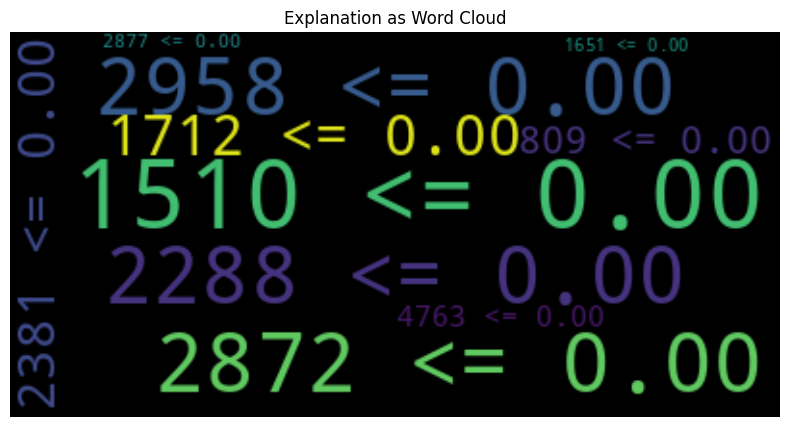

In [ ]:
from wordcloud import WordCloud
from lime import lime_tabular
# Create Lime Explainer
feature_names = np.arange(combined_features.shape[1])
class_names = [0, 1]
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=class_names, discretize_continuous=True)

# Explain instance
i = 55
instance = X_test[i].reshape(5006,)
exp = explainer.explain_instance(instance, rf_combined.predict_proba, num_features=10, top_labels=0)

words = {x[0]: abs(x[1]) for x in exp.as_list()}
wordcloud = WordCloud().generate_from_frequencies(words)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Explanation as Word Cloud")
plt.show()

In [ ]:
!pip install squarify

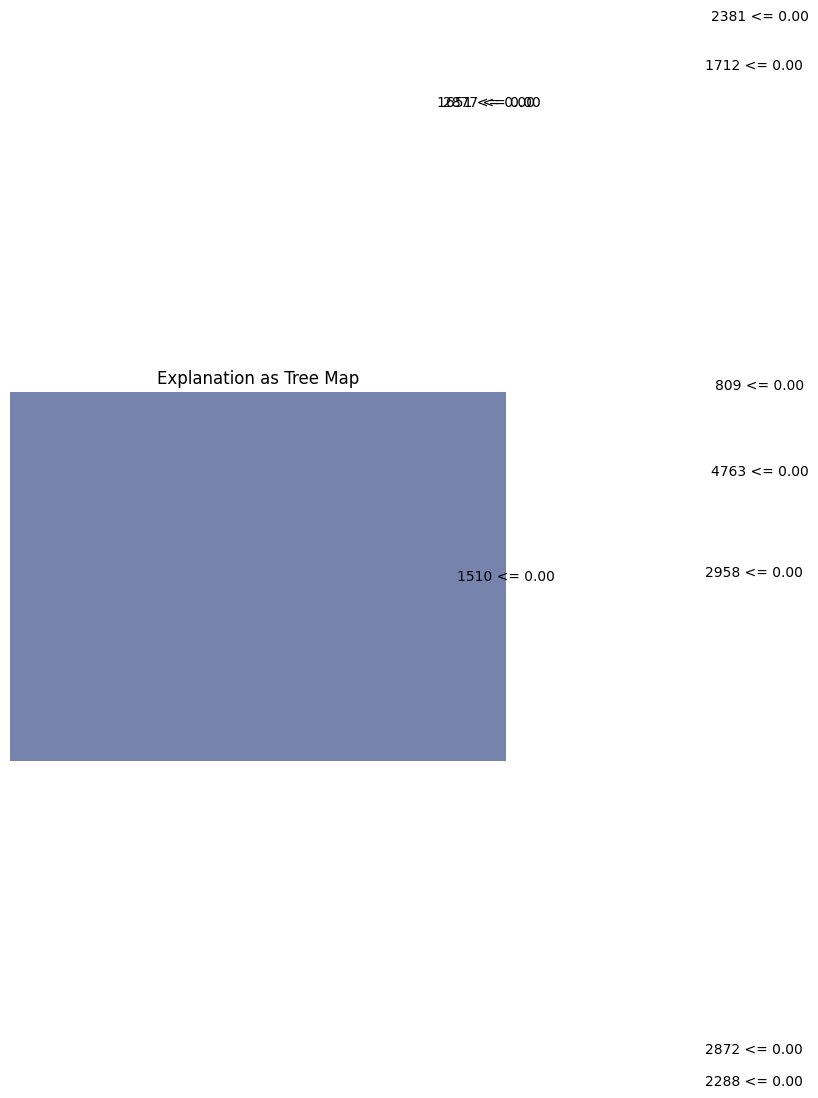

In [ ]:
import squarify

weights = {x[0]: x[1] for x in exp.as_list()}
squarify.plot(sizes=weights.values(), label=weights.keys(), alpha=.7)

plt.axis('off')
plt.title('Explanation as Tree Map')
plt.show()

In [ ]:
exp = explainer.explain_instance(X_test[i], rf_combined.predict_proba, num_features=10)

# Get dict of {feature: weight} pairs
feats = {x[0]:x[1] for x in exp.as_list()}

# Sort features by absolute weight
top10 = sorted(feats.items(), key=lambda x: abs(x[1]), reverse=True)[:10]

print("Top 10 contributing features:")
for feat, weight in top10:
    print(f"{feat}: {weight:.2f}")

Top 10 contributing features:
1804 <= 0.00: 0.20
3509 <= 0.00: 0.13
4131 <= 0.00: -0.12
679 <= 0.00: -0.10
1847 <= 0.00: -0.09
4284 <= 0.00: 0.09
1776 <= 0.00: -0.05
4391 <= 0.00: 0.04
3071 <= 0.00: 0.03
1386 <= 0.00: 0.03


In [ ]:
# Get index to word mapping
feature_names = np.array(vectorizer.get_feature_names_out())
index_to_word = {i: word for i, word in enumerate(feature_names)}

# Function to lookup token by index
def lookup_token(index):
    token = index_to_word.get(index)
    return token if token else str(index)

# Print mappings
print("Index 3411 maps to token:", lookup_token(3411))
print("Index 447 maps to token:", lookup_token(1266))

# Search DF for tweets containing token
token = lookup_token(3411)
df[df['clean_tweet'].str.contains(token)]

Index 3411 maps to token: programm
Index 447 maps to token: ducki


target         ids            user  \
3806        1  2066428633         tombo23   
5111        1  1990070226       amalinaaa   
13113       1  2014725866       alisohani   
3573        0  2266303887  genesisculture   
4618        0  1686563380   o0oChelseao0o   

                                               TweetText  \
3806   Found new programme - Dollhouse, it's pretty gd,    
5111   @Rebekah_McFly an adventure camp  omg why's Eo...   
13113  @selfexile Hilarious! -- On... Programmers hav...   
3573   I am Ruben, in charge of online operations. No...   
4618   1 protein shake down 3 more to go  sick of wei...   

                                             clean_tweet  kmeans_label  \
3806                      found programm dollhous pretti             0   
5111   rebekah mcfli adventur camp eoghan perform pro...             0   
13113             selfexil hilari programm life tahiriqb             0   
3573   ruben charg onlin oper work system code code c...             0   
4618             protein shake sick weight loss programm             0   

       nmf_feature_1  nmf_feature_2  
3806        0.002529       0.000482  
5111        0.000564       0.000127  
13113       0.001617       0.000543  
3573        0.000000       0.000384  
4618        0.002115       0.000087

In [ ]:
# Get vectorizer
vectorizer = TfidfVectorizer()

# NMF Model
nmf = NMF(n_components=5)
nmf.fit(vectorizer.fit_transform(df[['clean_tweet']]))

# Get NMF topic keywords
top_keywords = []
for topic_idx, topic in enumerate(nmf.components_):
    top_words = vectorizer.get_feature_names_out()[np.argsort(topic)[-10:]]
    top_keywords.append(top_words)
    print(f'Topic {topic_idx}: {", ".join(top_words)}')

# Map keyword to NMF topic
keyword = "programme"
keyword_vector = vectorizer.transform([keyword])

topic_dists = nmf.transform(keyword_vector)
most_similar_topic = np.argmax(topic_dists)

print(f"{keyword} maps to Topic {most_similar_topic}")
print(f"Keywords: {', '.join(top_keywords[most_similar_topic])}")

Topic 0: clean_tweet
Topic 1: clean_tweet
Topic 2: clean_tweet
Topic 3: clean_tweet
Topic 4: clean_tweet
programme maps to Topic 0
Keywords: clean_tweet


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(df['clean_tweet'])

# NMF Model
nmf = NMF(n_components=5)
nmf.fit(tfidf_features)

# Print topics
for topic_idx, topic in enumerate(nmf.components_):
    top_words = vectorizer.get_feature_names_out()[np.argsort(topic)[-10:]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

# Map keyword to NMF topic
keyword = "hi"
keyword_vector = vectorizer.transform([keyword])

topic_dists = nmf.transform(keyword_vector)
most_similar_topic = np.argmax(topic_dists)

print(f"{keyword} maps to Topic {most_similar_topic}")
print(f"Keywords: {', '.join(top_keywords[most_similar_topic])}")

Topic 0: back, time, home, know, realli, miss, want, like, today, feel
Topic 1: tonight, nice, time, readi, still, week, hour, tomorrow, back, work
Topic 2: gonna, live, make, rememb, play, like, twitter, song, watch, quot
Topic 3: feel, sleep, afternoon, twitter, hope, luck, everyon, night, morn, good
Topic 4: girl, song, show, weather, movi, watch, happi, much, thank, love
hi maps to Topic 0
Keywords: clean_tweet


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

# TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(df['clean_tweet'])

# NMF Model
nmf = NMF(n_components=15)
nmf.fit(tfidf_features)

# Print topics
for topic_idx, topic in enumerate(nmf.components_):
    top_words = vectorizer.get_feature_names_out()[np.argsort(topic)[-10:]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

# Map keyword to NMF topic
keyword = "feel"
keyword_vector = vectorizer.transform([keyword])

# Ensure the keyword vector has the same features as the training data
if keyword_vector.shape[1] != tfidf_features.shape[1]:
    raise ValueError("The number of features in the keyword vector is different from the training data.")

topic_dists = nmf.transform(keyword_vector)
most_similar_topic = np.argmax(topic_dists)

print(f"{keyword} maps to Topic {most_similar_topic}")
print(f"Keywords: {', '.join(top_words)}")


Topic 0: shit, littl, hate, much, make, hope, sick, better, well, feel
Topic 1: hate, tonight, still, done, readi, nice, week, hour, tomorrow, work
Topic 2: said, live, gonna, watch, rememb, make, play, song, twitter, quot
Topic 3: world, start, haha, afternoon, twitter, hope, luck, everyon, morn, good
Topic 4: birthday, song, girl, movi, show, hate, weather, much, happi, love
Topic 5: someon, even, gone, come, alreadi, gonna, babi, friend, much, miss
Topic 6: talk, know, friend, bore, take, iphon, leav, twitter, dont, want
Topic 7: hope, cool, appreci, followfriday, twitter, well, great, much, follow, thank
Topic 8: beauti, nice, look, gonna, rain, home, happi, wish, hope, today
Topic 9: wait, movi, cant, tire, tomorrow, still, need, watch, think, sleep
Topic 10: week, tweet, hour, tomorrow, head, wait, school, come, home, back
Topic 11: enjoy, tonight, final, late, everyon, great, tomorrow, week, last, night
Topic 12: long, take, hope, start, wish, first, week, next, great, time
Topi

In [ ]:
# Map keyword to NMF topic
keyword = "movie"
keyword_vector = vectorizer.transform([keyword])

# Ensure the keyword vector has the same features as the training data
if keyword_vector.shape[1] != tfidf_features.shape[1]:
    raise ValueError("The number of features in the keyword vector is different from the training data.")

topic_dists = nmf.transform(keyword_vector)
most_similar_topic = np.argmax(topic_dists)

print(f"{keyword} maps to Topic {most_similar_topic}")
print(f"Keywords: {', '.join(top_words)}")


movie maps to Topic 10
Keywords: haha, rain, thing, peopl, dont, would, sound, look, know, like


Topic 0: good, morn, feel, night, today, like, hope, time, know, sleep
Topic 1: thank, follow, followfriday, great, like, hope, realli, appreci, know, need
Topic 2: work, want, tomorrow, time, today, home, sleep, week, hour, need
Topic 3: love, quot, like, watch, happi, know, time, look, make, twitter
Topic 4: miss, realli, know, want, home, come, friend, think, alreadi, wait


<ipython-input-73-371969e66a47>:29: RuntimeWarning: invalid value encountered in divide
  normalized_matrix = document_topic_matrix / document_topic_matrix.sum(axis=1, keepdims=True)


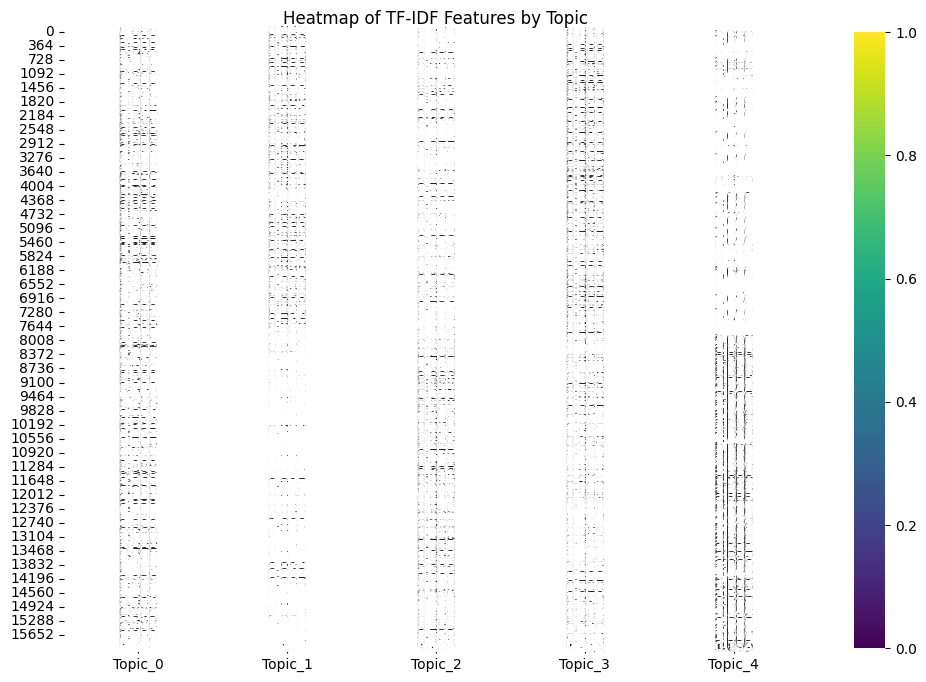

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Assuming df contains your preprocessed data with 'clean_tweet' column

# Feature Extraction with TF-IDF and NMF
vectorizer = TfidfVectorizer(max_features=5000, max_df=0.85, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['clean_tweet'])

num_topics = 5  # You can adjust the number of topics based on your analysis needs
nmf = NMF(n_components=num_topics, random_state=42)
nmf_features = nmf.fit_transform(tfidf_matrix)

# Extract topic keywords
topic_keywords = []
for topic_idx, topic in enumerate(nmf.components_):
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
    topic_keywords.append(top_words)
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

# Create document-topic matrix
document_topic_matrix = nmf.transform(tfidf_matrix)

# Normalize the matrix
normalized_matrix = document_topic_matrix / document_topic_matrix.sum(axis=1, keepdims=True)

# Create a DataFrame for visualization
topic_names = [f"Topic_{i}" for i in range(num_topics)]
heatmap_data = pd.DataFrame(normalized_matrix, columns=topic_names)

# Plot the heatmap
plt.figure(figsize=(12, 8))
plt.title('Heatmap of TF-IDF Features by Topic')
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".3f", linewidths=.5)
plt.show()


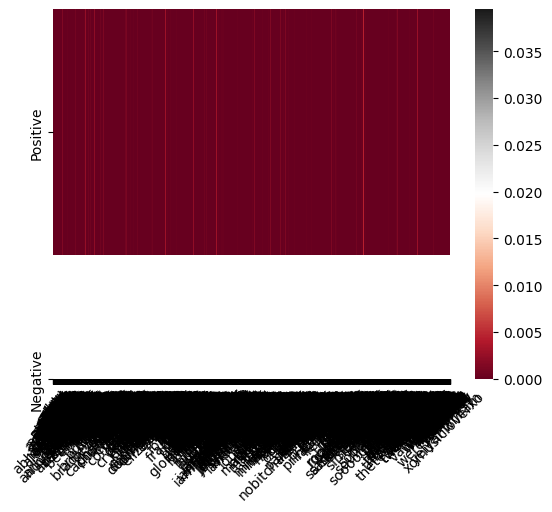

In [ ]:
# Separate TF-IDF ,KMeans, and NMF features
tfidf_features = combined_features[:, :tfidf_matrix.shape[1]]
nmf_features = combined_features[:, tfidf_matrix.shape[1]:]

# Get feature importances
rf_combined_importances = rf_combined.feature_importances_

# Map importances to feature sets
tfidf_importances = rf_combined_importances[:tfidf_matrix.shape[1]]
combined_importances = rf_combined_importances[tfidf_matrix.shape[1]:]

# Combine feature sets and importances
feature_names = np.concatenate([vectorizer.get_feature_names_out(), [f"Topic {i+1}" for i in range(num_topics)]])
combined_importances = np.concatenate([tfidf_importances, combined_importances])

# Create the heatmap
sns.heatmap(combined_importances.reshape(1, -1), xticklabels=feature_names, yticklabels=["Positive", "Negative"], cmap="RdGy")
plt.xticks(rotation=45)
plt.show()

In [ ]:


# Train and Evaluate Decision Tree on Original TF-IDF Features
dt_original = DecisionTreeClassifier(random_state=42)
dt_original.fit(X_train[:, :tfidf_matrix.shape[1]], y_train)

# Predictions on training set
y_train_pred_dt_original = dt_original.predict(X_train[:, :tfidf_matrix.shape[1]])

# Predictions on testing set
y_test_pred_dt_original = dt_original.predict(X_test[:, :tfidf_matrix.shape[1]])

# Accuracy for training set
accuracy_dt_train_original = accuracy_score(y_train, y_train_pred_dt_original)
print("\nAccuracy with Original TF-IDF Features on Training Set (Decision Tree):", accuracy_dt_train_original)

# Accuracy for testing set
accuracy_dt_original = accuracy_score(y_test, y_test_pred_dt_original)
print("\nAccuracy with Original TF-IDF Features on Testing Set (Decision Tree):", accuracy_dt_original)
print("Classification Report for Original TF-IDF Features (Decision Tree):\n", classification_report(y_test, y_test_pred_dt_original))

# Train and Evaluate Decision Tree on Combined Features (TF-IDF + NMF + Kmeans)
dt_combined = DecisionTreeClassifier(random_state=42)
dt_combined.fit(combined_features, df['target'])

# Predictions on training set
y_train_pred_dt_combined = dt_combined.predict(X_train)

# Predictions on testing set
y_test_pred_dt_combined = dt_combined.predict(X_test)

# Accuracy for training set
accuracy_dt_train_combined = accuracy_score(y_train, y_train_pred_dt_combined)
print("\nAccuracy with Combined Features (TF-IDF + NMF + KMeans) on Training Set (Decision Tree):", accuracy_dt_train_combined)

# Accuracy for testing set
accuracy_dt_combined = accuracy_score(y_test, y_test_pred_dt_combined)
print("\nAccuracy with Combined Features (TF-IDF + NMF + KMeans) on Testing Set (Decision Tree):", accuracy_dt_combined)
print("Classification Report for Combined Features (Decision Tree):\n", classification_report(y_test, y_test_pred_dt_combined))



Accuracy with Original TF-IDF Features on Training Set (Decision Tree): 0.8465625

Accuracy with Original TF-IDF Features on Testing Set (Decision Tree): 0.543125
Classification Report for Original TF-IDF Features (Decision Tree):
               precision    recall  f1-score   support

           0       0.59      0.34      0.43      1623
           1       0.53      0.75      0.62      1577

    accuracy                           0.54      3200
   macro avg       0.56      0.55      0.52      3200
weighted avg       0.56      0.54      0.52      3200



ValueError: ignored

In [ ]:
# Import necessary libraries
import lime
from lime import lime_text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

# Sample data (replace with your actual data)
# Assuming df is your DataFrame with 'clean_tweet' column and 'label' column
texts = df['TweetText'].tolist()
labels = df['target'].tolist()

# Create a CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

# Create a classifier (replace with your actual model)
classifier = make_pipeline(vectorizer, Dec())
classifier.fit(texts, labels)

# Create the LIME explainer
explainer = lime_text.LimeTextExplainer()

# Select an instance for which you want to explain the prediction
instance_idx = 0
instance = texts[instance_idx]

# Explain the prediction using LIME
explanation = explainer.explain_instance(instance, classifier.predict_proba)

# Visualize the explanation
explanation.show_in_notebook(text=True)


In [ ]:
# Train and Evaluate SVM on Original TF-IDF Features
svm_original = SVC(random_state=42)
svm_original.fit(X_train[:, :tfidf_matrix.shape[1]], y_train)

# Predictions on training set
y_train_pred_svm_original = svm_original.predict(X_train[:, :tfidf_matrix.shape[1]])

# Predictions on testing set
y_test_pred_svm_original = svm_original.predict(X_test[:, :tfidf_matrix.shape[1]])

# Accuracy for training set
accuracy_svm_train_original = accuracy_score(y_train, y_train_pred_svm_original)
print("\nAccuracy with Original TF-IDF Features on Training Set (SVM):", accuracy_svm_train_original)

# Accuracy for testing set
accuracy_svm_original = accuracy_score(y_test, y_test_pred_svm_original)
print("\nAccuracy with Original TF-IDF Features on Testing Set (SVM):", accuracy_svm_original)
print("Classification Report for Original TF-IDF Features (SVM):\n", classification_report(y_test, y_test_pred_svm_original))

# Train and Evaluate SVM on Combined Features (TF-IDF + NMF + Kmeans)
svm_combined = SVC(random_state=42)
svm_combined.fit(combined_features, df['target'])

# Predictions on training set
y_train_pred_svm_combined = svm_combined.predict(X_train)

# Predictions on testing set
y_test_pred_svm_combined = svm_combined.predict(X_test)

# Accuracy for training set
accuracy_svm_train_combined = accuracy_score(y_train, y_train_pred_svm_combined)
print("\nAccuracy with Combined Features (TF-IDF + NMF + Kmeans) on Training Set (SVM):", accuracy_svm_train_combined)

# Accuracy for testing set
accuracy_svm_combined = accuracy_score(y_test, y_test_pred_svm_combined)
print("\nAccuracy with Combined Features (TF-IDF + NMF + Kmeans) on Testing Set (SVM):", accuracy_svm_combined)
print("Classification Report for Combined Features (SVM):\n", classification_report(y_test, y_test_pred_svm_combined))


Accuracy with Original TF-IDF Features on Training Set (SVM): 0.931171875

Accuracy with Original TF-IDF Features on Testing Set (SVM): 0.70625
Classification Report for Original TF-IDF Features (SVM):
               precision    recall  f1-score   support

           0       0.71      0.69      0.70      1593
           1       0.70      0.72      0.71      1607

    accuracy                           0.71      3200
   macro avg       0.71      0.71      0.71      3200
weighted avg       0.71      0.71      0.71      3200


Accuracy with Combined Features (TF-IDF + NMF + Kmeans) on Training Set (SVM): 0.85703125

Accuracy with Combined Features (TF-IDF + NMF + Kmeans) on Testing Set (SVM): 0.8496875
Classification Report for Combined Features (SVM):
               precision    recall  f1-score   support

           0       0.86      0.83      0.85      1593
           1       0.84      0.87      0.85      1607

    accuracy                           0.85      3200
   macro avg       

In [ ]:



# Train and Evaluate Naive Bayes on Original TF-IDF Features
nb_original = MultinomialNB()
nb_original.fit(X_train[:, :tfidf_matrix.shape[1]], y_train)

# Predictions on training set
y_train_pred_nb_original = nb_original.predict(X_train[:, :tfidf_matrix.shape[1]])

# Predictions on testing set
y_test_pred_nb_original = nb_original.predict(X_test[:, :tfidf_matrix.shape[1]])

# Accuracy for training set
accuracy_nb_train_original = accuracy_score(y_train, y_train_pred_nb_original)
print("\nAccuracy with Original TF-IDF Features on Training Set (Naive Bayes):", accuracy_nb_train_original)

# Accuracy for testing set
accuracy_nb_original = accuracy_score(y_test, y_test_pred_nb_original)
print("\nAccuracy with Original TF-IDF Features on Testing Set (Naive Bayes):", accuracy_nb_original)
print("Classification Report for Original TF-IDF Features (Naive Bayes):\n", classification_report(y_test, y_test_pred_nb_original))

# Train and Evaluate Naive Bayes on Combined Features (TF-IDF + NMF + Kmeans)
nb_combined = MultinomialNB()
nb_combined.fit(combined_features, df['target'])

# Predictions on training set
y_train_pred_nb_combined = nb_combined.predict(X_train)

# Predictions on testing set
y_test_pred_nb_combined = nb_combined.predict(X_test)

# Accuracy for training set
accuracy_nb_train_combined = accuracy_score(y_train, y_train_pred_nb_combined)
print("\nAccuracy with Combined Features (TF-IDF + NMF + Kmeans) on Training Set (Naive Bayes):", accuracy_nb_train_combined)

# Accuracy for testing set
accuracy_nb_combined = accuracy_score(y_test, y_test_pred_nb_combined)
print("\nAccuracy with Combined Features (TF-IDF + NMF + Kmeans) on Testing Set (Naive Bayes):", accuracy_nb_combined)
print("Classification Report for Combined Features (Naive Bayes):\n", classification_report(y_test, y_test_pred_nb_combined))


Accuracy with Original TF-IDF Features on Training Set (Naive Bayes): 0.80921875

Accuracy with Original TF-IDF Features on Testing Set (Naive Bayes): 0.6984375
Classification Report for Original TF-IDF Features (Naive Bayes):
               precision    recall  f1-score   support

           0       0.70      0.70      0.70      1593
           1       0.70      0.70      0.70      1607

    accuracy                           0.70      3200
   macro avg       0.70      0.70      0.70      3200
weighted avg       0.70      0.70      0.70      3200


Accuracy with Combined Features (TF-IDF + NMF + Kmeans) on Training Set (Naive Bayes): 0.79984375

Accuracy with Combined Features (TF-IDF + NMF + Kmeans) on Testing Set (Naive Bayes): 0.8
Classification Report for Combined Features (Naive Bayes):
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      1593
           1       0.80      0.80      0.80      1607

    accuracy                  

In [ ]:

# Train and Evaluate XGBoost on Original TF-IDF Features
xgb_original = XGBClassifier(random_state=42)
xgb_original.fit(X_train[:, :tfidf_matrix.shape[1]], y_train)

# Predictions on training set
y_train_pred_xgb_original = xgb_original.predict(X_train[:, :tfidf_matrix.shape[1]])

# Predictions on testing set
y_test_pred_xgb_original = xgb_original.predict(X_test[:, :tfidf_matrix.shape[1]])

# Accuracy for training set
accuracy_xgb_train_original = accuracy_score(y_train, y_train_pred_xgb_original)
print("\nAccuracy with Original TF-IDF Features on Training Set (XGBoost):", accuracy_xgb_train_original)

# Accuracy for testing set
accuracy_xgb_original = accuracy_score(y_test, y_test_pred_xgb_original)
print("\nAccuracy with Original TF-IDF Features on Testing Set (XGBoost):", accuracy_xgb_original)
print("Classification Report for Original TF-IDF Features (XGBoost):\n", classification_report(y_test, y_test_pred_xgb_original))

# Train and Evaluate XGBoost on Combined Features (TF-IDF + NMF + Kmeans)
xgb_combined = XGBClassifier(random_state=42)
xgb_combined.fit(combined_features, df['target'])

# Predictions on training set
y_train_pred_xgb_combined = xgb_combined.predict(X_train)

# Predictions on testing set
y_test_pred_xgb_combined = xgb_combined.predict(X_test)

# Accuracy for training set
accuracy_xgb_train_combined = accuracy_score(y_train, y_train_pred_xgb_combined)
print("\nAccuracy with Combined Features (TF-IDF + NMF + Kmeans) on Training Set (XGBoost):", accuracy_xgb_train_combined)

# Accuracy for testing set
accuracy_xgb_combined = accuracy_score(y_test, y_test_pred_xgb_combined)
print("\nAccuracy with Combined Features (TF-IDF + NMF + Kmeans) on Testing Set (XGBoost):", accuracy_xgb_combined)
print("Classification Report for Combined Features (XGBoost):\n", classification_report(y_test, y_test_pred_xgb_combined))


Accuracy with Original TF-IDF Features on Training Set (XGBoost): 0.756015625

Accuracy with Original TF-IDF Features on Testing Set (XGBoost): 0.6828125
Classification Report for Original TF-IDF Features (XGBoost):
               precision    recall  f1-score   support

           0       0.72      0.59      0.65      1593
           1       0.66      0.77      0.71      1607

    accuracy                           0.68      3200
   macro avg       0.69      0.68      0.68      3200
weighted avg       0.69      0.68      0.68      3200


Accuracy with Combined Features (TF-IDF + NMF + Kmeans) on Training Set (XGBoost): 0.761953125

Accuracy with Combined Features (TF-IDF + NMF + Kmeans) on Testing Set (XGBoost): 0.7646875
Classification Report for Combined Features (XGBoost):
               precision    recall  f1-score   support

           0       0.78      0.73      0.76      1593
           1       0.75      0.80      0.77      1607

    accuracy                           0.76   

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


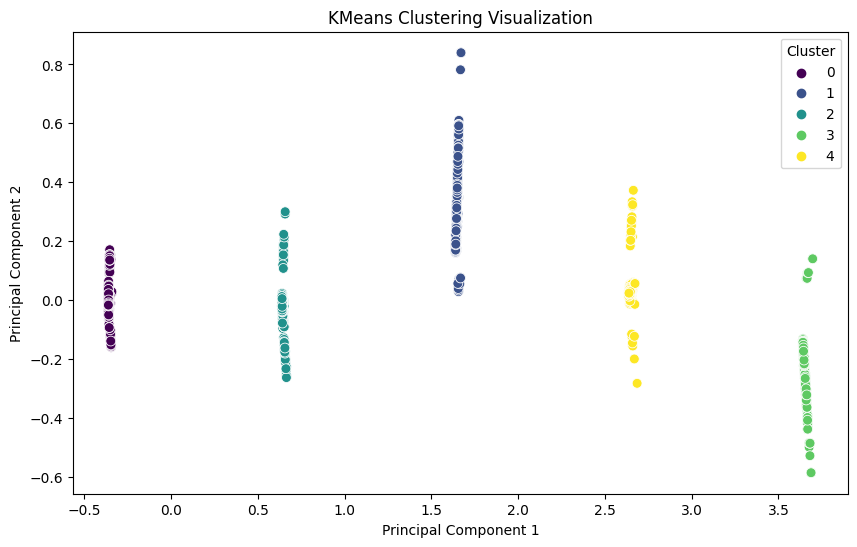

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Assuming you have a variable 'combined_features' containing your combined features
# If not, replace it with the appropriate feature matrix

# Apply PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(combined_features)

# Fit KMeans on the reduced features
num_clusters = 5  # You can adjust the number of clusters based on your analysis needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(reduced_features)

# Add cluster labels to the original dataframe (assuming you have a dataframe df)
df['Cluster'] = kmeans.labels_

# Visualize the clusters in a 2D scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=df['Cluster'], palette='viridis', s=50)
plt.title('KMeans Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


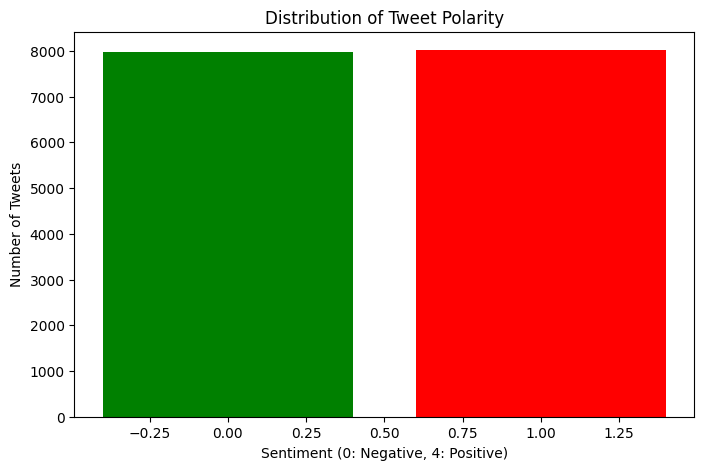

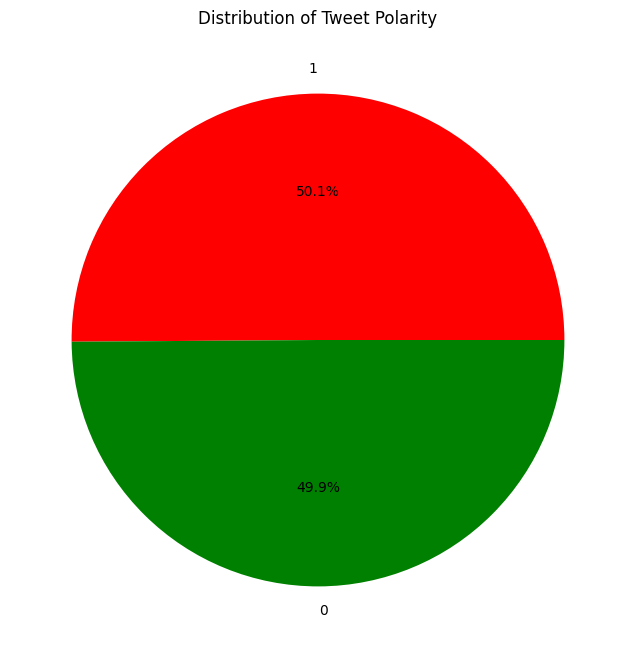

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the 'target' column with tweet polarity (0 for negative, 4 for positive)
# You can modify this based on your actual DataFrame structure

# Count the occurrences of each sentiment label
sentiment_counts = df['target'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'green'])
plt.title('Distribution of Tweet Polarity')
plt.xlabel('Sentiment (0: Negative, 4: Positive)')
plt.ylabel('Number of Tweets')
plt.show()

# Alternatively, create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['red', 'green'])
plt.title('Distribution of Tweet Polarity')
plt.show()


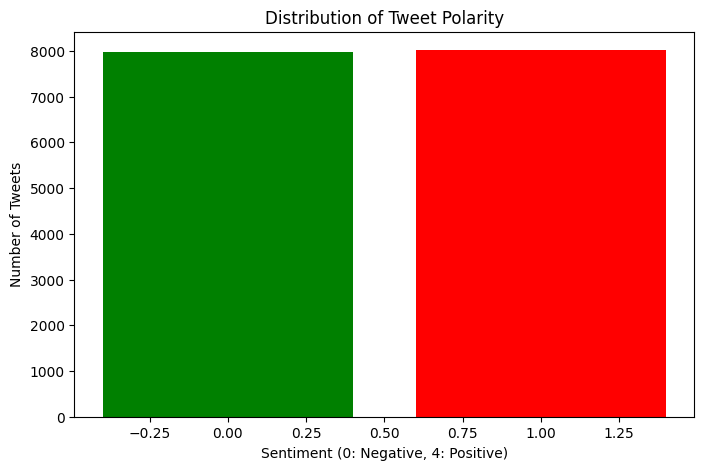

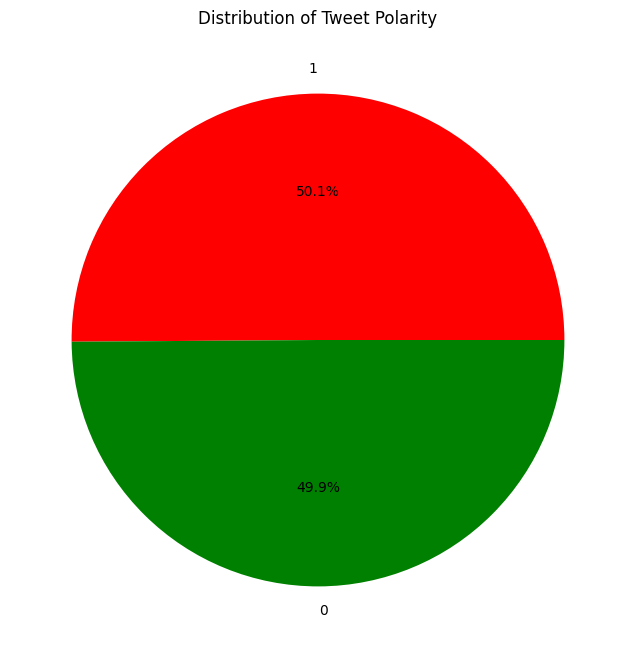

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the 'target' column with tweet polarity (0 for negative, 4 for positive)
# You can modify this based on your actual DataFrame structure

# Count the occurrences of each sentiment label
sentiment_counts = df['target'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'green'])
plt.title('Distribution of Tweet Polarity')
plt.xlabel('Sentiment (0: Negative, 4: Positive)')
plt.ylabel('Number of Tweets')

# Save the bar chart as PNG
plt.savefig('distribution_bar_chart.png', format='png')
# Save the bar chart as JPG
plt.savefig('distribution_bar_chart.jpg', format='jpg')

# Alternatively, create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['red', 'green'])
plt.title('Distribution of Tweet Polarity')

# Save the pie chart as PNG
plt.savefig('distribution_pie_chart.png', format='png')
# Save the pie chart as JPG
plt.savefig('distribution_pie_chart.jpg', format='jpg')

# Show the plots
plt.show()
